# IMPORTS

In [67]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

# CLASSES + HELPERS

In [74]:
class IMG_PROCESSING():

  def __init__(self, img_path, mu=0., sigma=1., prob=0.5):
    self.img = cv.imread(img_path)
    self.mu = mu
    self.sigma = sigma
    self.prob = prob 
  
  def show_img(self, img, img_type='rgb'):
    if img_type == 'gray':
      plt.imshow(img, cmap=plt.get_cmap(img_type))
    else:
      plt.imshow(img)
    plt.show()

  def myColorToGray(self):
    self.gray_img = np.dot(self.img[...,:3], [0.2989, 0.5870, 0.1140])
  
  def myImNoise(self, img, noise_type):
    if noise_type == 'gaussian':
      self.gauss_img = img + np.random.normal(self.mu, self.sigma, img.shape)
    elif noise_type == 'saltandpepper':
      rows, cols = img.shape
      self.sap_img = img
      for i in range(rows):
        for j in range(cols):
          rdn = np.random.random()
          if rdn < self.prob:
              self.sap_img[i][j] = 0
          elif rdn > 1-self.prob:
              self.sap_img[i][j] = 255
  
  def print_wrong_dims(self, img, kernel):
    print("Invalid input(s)!!!")
    if (img.ndim != 2) and (kernel.ndim != 2):
      print("Input image and kernel are not 2D!")
    elif img.ndim != 2:
      print("Input image is not 2D!")
    elif kernel.ndim != 2:
      print("Kernel is not 2D!")
  
  def myConv2(self, img, kernel, padding='same', mask_type=None):

    if (img.ndim == 2) and (kernel.ndim == 2):
      # flip kernel horizontally and vertically
      kernel = np.flipud(np.fliplr(kernel))

      # get shapes
      N_in, D_in = img.shape
      k, d = kernel.shape
      
      if (k < N_in) and (d < D_in):
        if padding == 'same':
          pad = k-1
          N_out, D_out = int(N_in), int(D_in)
          img_padded = np.zeros((N_in + pad, D_in + pad))
          img_padded[int(pad/2):-int(pad/2), int(pad/2):-int(pad/2)] = img
        elif padding == 'valid':
          N_out, D_out = int(N_in - k + 1), int(D_in - d + 1)
          img_padded = img
        else:
          print("Not valid 'padding' input")
          return None
      
        # initialize output matrix
        conv_img = np.zeros((N_out, D_out))
        
        if mask_type == None:   
          for i in range(N_out):   # iterate through the ROWS of the OUTPUT image
            for j in range(D_out):   # iterate through the COLUMNS of the OUTPUT image
              conv_img[i, j] += np.multiply(img_padded[i:i+k, j:j+k], kernel).sum().sum()
        elif mask_type == 'median':
          for i in range(N_out):  # iterate through the ROWS of the OUTPUT image
            for j in range(D_out):  # iterate through the COLUMNS of the OUTPUT image
              conv_img[i, j] += np.median(np.multiply(img_padded[i:i+k, j:j+k], kernel))   
        else:
          print("This mask type is not supported!")       
        return conv_img
      else:
        print("The dimensions of the kernel must be <= than the corresponding dimensions of the input image")
    else:
      self.print_wrong_dims(img, kernel)
  
  def myImFilter(self, img, filter_type, filter_height, filter_width, padding):
    img_heigth, img_width = img.shape
    if (filter_height > img_heigth) or (filter_width > img_width):
      print("Not valid filter size! The dimensions of the filter should less or equal to the corresponding image dimensions")
    else:
      if filter_type == 'mean':
        kernel = (1/filter_height/filter_width) * np.ones((filter_height, filter_width))
        self.mean_filt_img = self.myConv2(img, kernel, padding)
      elif filter_type == 'median':
        kernel = np.ones((filter_height, filter_width))
        self.median_filt_img = self.myConv2(img, kernel, padding, filter_type)
      else:
        print("This type of filter is not supported! Only 'mean' and 'median' are supproted as filter types.")
  
  def myEdgeDetection(self, img, edge_det_type):
    if img.ndim == 2:
      if edge_det_type == "Sobel":
        kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        self.img_sobel_vert = self.myConv2(img, kernel, padding='same')
        self.img_sobel_horz = self.myConv2(img, np.flip(kernel.T, axis=0), padding='same')
      elif edge_det_type == "Prewitt":
        vert_kernel = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
        self.img_prewitt_vert = self.myConv2(img, vert_kernel, padding='same')
        horz_kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        self.img_prewitt_horz = self.myConv2(img, horz_kernel, padding='same')    
      elif edge_det_type == "Laplace":
        kernel_1 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
        self.img_laplace_1 = self.myConv2(img, kernel_1, padding='same')
        kernel_2 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        self.img_laplace_2 = self.myConv2(img, kernel_2, padding='same')         
    else:
      print("Input image is not 2D!")


# demo1.py - lena.png

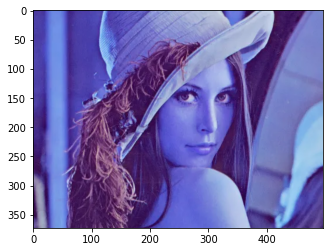

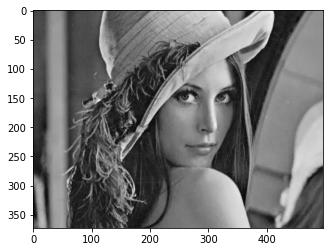

In [75]:
# SET CONSTANTS
lena_path = "/content/lena.png"
mu, sigma, prob =1., 2., 0.1

# READ AND SHOW IMAGE
img_obj = IMG_PROCESSING(lena_path, mu=mu, sigma=sigma, prob=prob)
img_obj.show_img(img_obj.img)

# TURN IMAGE TO GRAY-SCALE
img_obj.myColorToGray()
A = img_obj.gray_img
img_obj.show_img(A, 'gray')

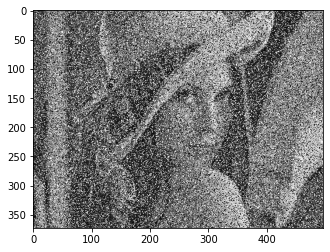

In [78]:
# ADD "GAUSSIAN" NOISE TO THE IMAGE
img_obj.myImNoise(A, 'saltandpepper')
B = img_obj.sap_img
img_obj.show_img(B, "gray")

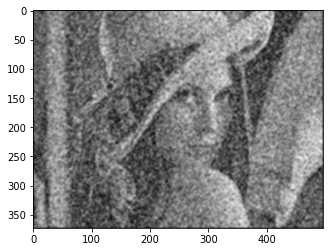

In [81]:
# USE THE "MEAN" FILTER TO DENOISE THE IMAGE
img_obj.myImFilter(B, 'mean', 5, 5, 'same')
C = img_obj.mean_filt_img
img_obj.show_img(C, 'gray')

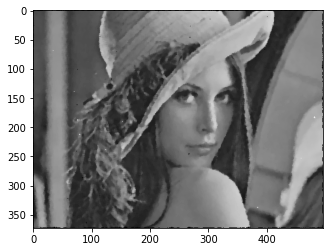

In [82]:
# USE THE "MEDIAN" FILTER TO DENOISE THE IMAGE
img_obj.myImFilter(B, 'median', 5, 5, 'same')
C = img_obj.median_filt_img
img_obj.show_img(C, 'gray')

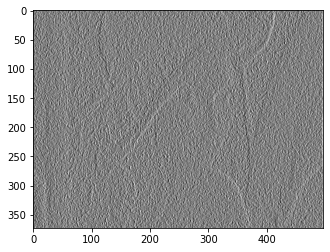

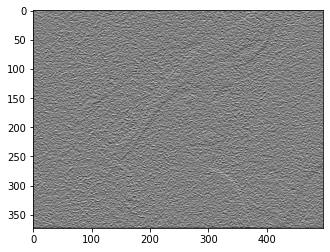

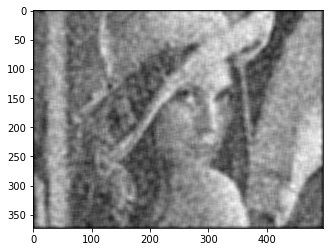

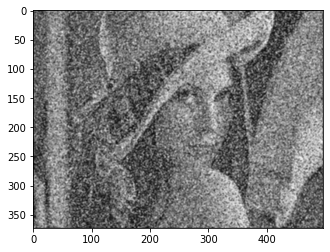

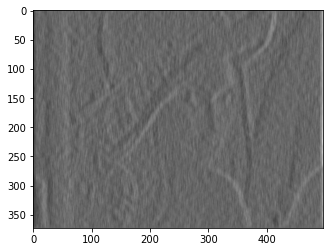

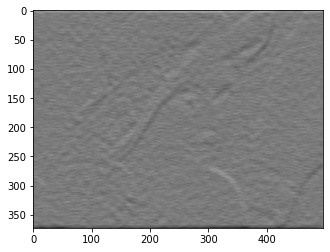

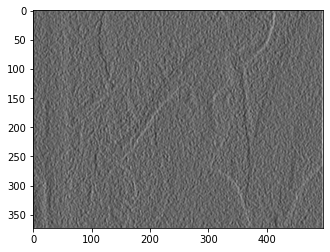

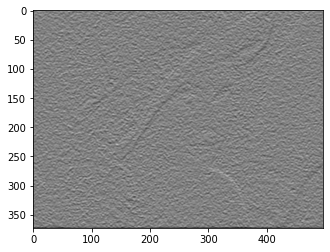

In [84]:
# TEST "SOBEL" EDGE DETECTION FILTER ON "A"
img_obj.myEdgeDetection(A, "Sobel")
A_edge_vert = img_obj.img_sobel_vert
A_edge_horz = img_obj.img_sobel_horz
img_obj.show_img(A_edge_vert, 'gray')
img_obj.show_img(A_edge_horz, 'gray')

# CREATE "E" AND "F" IMAGES
img_obj.myImFilter(A, 'mean', 9, 9, 'same')
E = img_obj.mean_filt_img
img_obj.show_img(E, 'gray')

img_obj.myImFilter(A, 'mean', 3, 3, 'same')
F = img_obj.mean_filt_img
img_obj.show_img(F, 'gray')

# TEST "SOBEL" EDGE DETECTION FILTER ON "E"
img_obj.myEdgeDetection(E, "Sobel")
E_edge_vert = img_obj.img_sobel_vert
E_edge_horz = img_obj.img_sobel_horz
img_obj.show_img(E_edge_vert, 'gray')
img_obj.show_img(E_edge_horz, 'gray')

# TEST "SOBEL" EDGE DETECTION FILTER ON "F"
img_obj.myEdgeDetection(F, "Sobel")
F_edge_vert = img_obj.img_sobel_vert
F_edge_horz = img_obj.img_sobel_horz
img_obj.show_img(F_edge_vert, 'gray')
img_obj.show_img(F_edge_horz, 'gray')

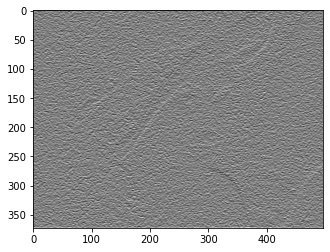

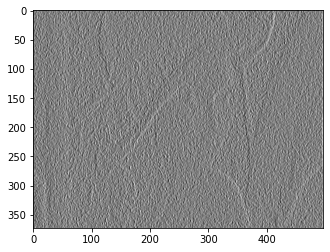

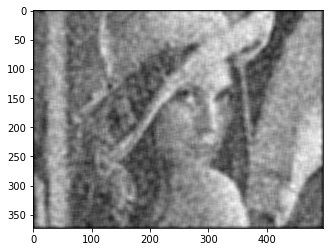

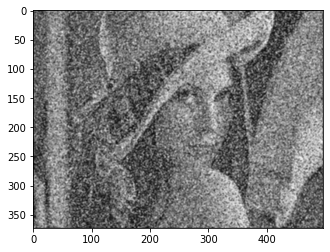

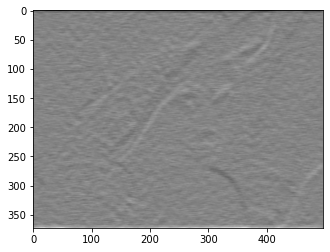

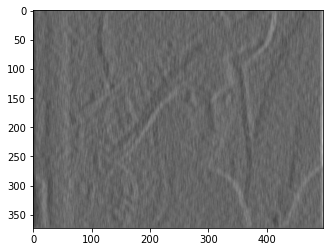

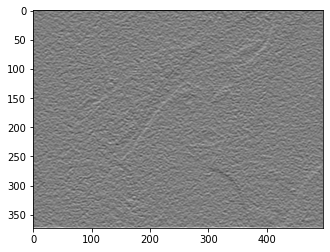

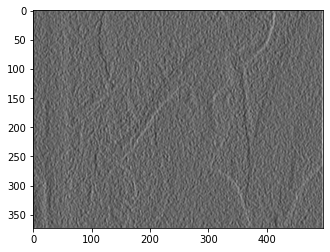

In [86]:
# TEST "PREWITT" EDGE DETECTION FILTER ON "A"
img_obj.myEdgeDetection(A, "Prewitt")
A_edge_vert = img_obj.img_prewitt_vert
A_edge_horz = img_obj.img_prewitt_horz
img_obj.show_img(A_edge_vert, 'gray')
img_obj.show_img(A_edge_horz, 'gray')

# CREATE "E" AND "F" IMAGES
img_obj.myImFilter(A, 'mean', 9, 9, 'same')
E = img_obj.mean_filt_img
img_obj.show_img(E, 'gray')

img_obj.myImFilter(A, 'mean', 3, 3, 'same')
F = img_obj.mean_filt_img
img_obj.show_img(F, 'gray')

# TEST "PREWITT" EDGE DETECTION FILTER ON "E"
img_obj.myEdgeDetection(E, "Prewitt")
E_edge_vert = img_obj.img_prewitt_vert
E_edge_horz = img_obj.img_prewitt_horz
img_obj.show_img(E_edge_vert, 'gray')
img_obj.show_img(E_edge_horz, 'gray')

# TEST "PREWITT" EDGE DETECTION FILTER ON "F"
img_obj.myEdgeDetection(F, "Prewitt")
F_edge_vert = img_obj.img_prewitt_vert
F_edge_horz = img_obj.img_prewitt_horz
img_obj.show_img(F_edge_vert, 'gray')
img_obj.show_img(F_edge_horz, 'gray')

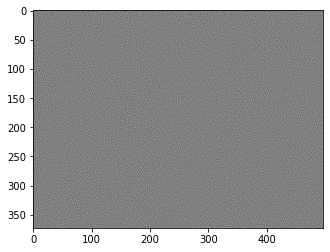

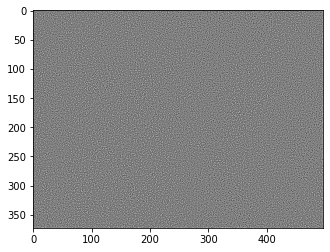

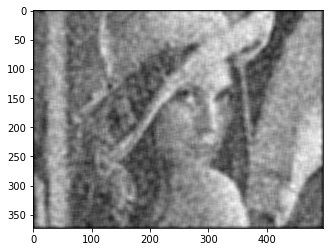

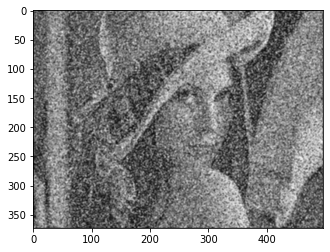

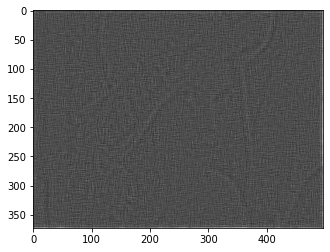

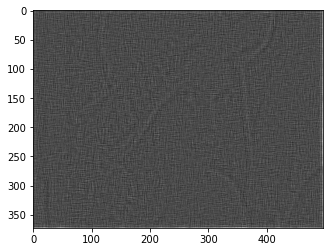

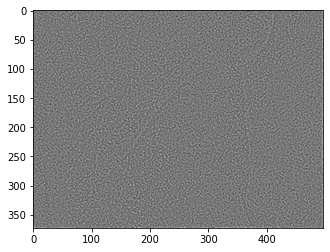

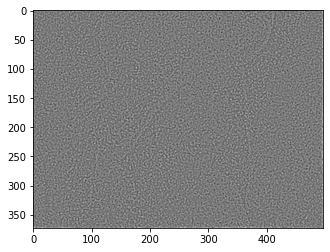

In [87]:
# TEST "LAPLACE" EDGE DETECTION FILTER ON "A"
img_obj.myEdgeDetection(A, "Laplace")
A_edge_1 = img_obj.img_laplace_1
A_edge_2 = img_obj.img_laplace_2
img_obj.show_img(A_edge_1, 'gray')
img_obj.show_img(A_edge_2, 'gray')

# CREATE "E" AND "F" IMAGES
img_obj.myImFilter(A, 'mean', 9, 9, 'same')
E = img_obj.mean_filt_img
img_obj.show_img(E, 'gray')

img_obj.myImFilter(A, 'mean', 3, 3, 'same')
F = img_obj.mean_filt_img
img_obj.show_img(F, 'gray')

# TEST "LAPLACE" EDGE DETECTION FILTER ON "E"
img_obj.myEdgeDetection(E, "Laplace")
E_edge_1 = img_obj.img_laplace_1
E_edge_2 = img_obj.img_laplace_2
img_obj.show_img(E_edge_1, 'gray')
img_obj.show_img(E_edge_2, 'gray')

# TEST "LAPLACE" EDGE DETECTION FILTER ON "F"
img_obj.myEdgeDetection(F, "Laplace")
F_edge_1 = img_obj.img_laplace_1
F_edge_2 = img_obj.img_laplace_2
img_obj.show_img(F_edge_1, 'gray')
img_obj.show_img(F_edge_2, 'gray')

# 1. OPEN CV LOGO

In [57]:
# SET CONSTANTS
cv_logo_path = '/content/opencv_logo.png'
mu, sigma, prob =1., 2., 0.1

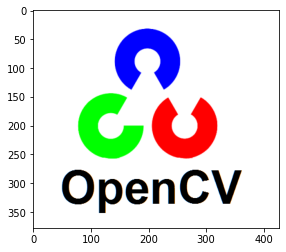

In [58]:
# READ IMAGE
img_obj = IMG_PROCESSING(cv_logo_path, mu=mu, sigma=sigma, prob=prob)
img_obj.show_img(img_obj.img)

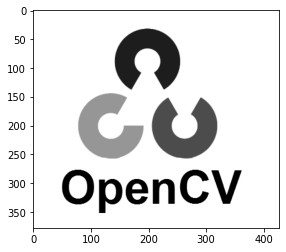

In [59]:
# 1. test myColorToGray
img_obj.myColorToGray()
img_obj.show_img(img_obj.gray_img, 'gray')

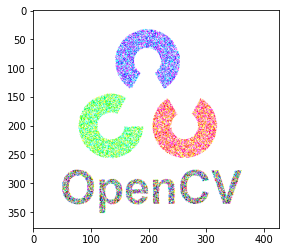

In [60]:
# 2a. test "Gaussian" noise
img_obj.myImNoise(img_obj.img, 'gaussian')
img_obj.show_img(img_obj.gauss_img)

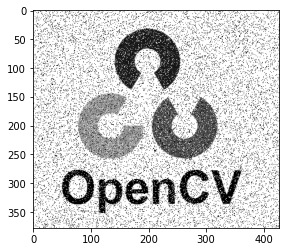

In [61]:
# 2a. test "Salt and Pepper" noise
img_obj.myImNoise(img_obj.gray_img, 'saltandpepper')
img_obj.show_img(img_obj.sap_img, 'gray')

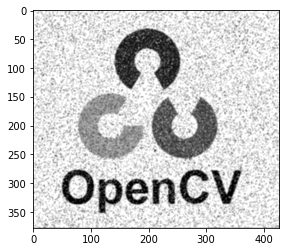

In [62]:
# 3. test mean filter
img_obj.myImFilter(img_obj.gray_img, 'mean', 3, 3, 'same')
img_obj.show_img(img_obj.mean_filt_img, 'gray')

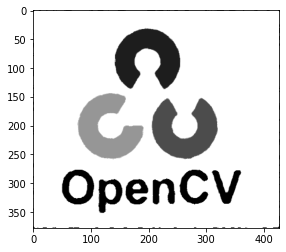

In [63]:
# 4. test median filter
img_obj.myImFilter(img_obj.gray_img, 'median', 7, 7, 'same')
img_obj.show_img(img_obj.median_filt_img, 'gray')

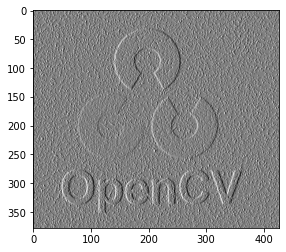

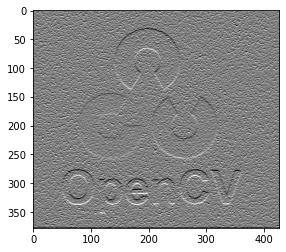

In [64]:
# 5a. test Sobel edge detection filter
img_obj.myEdgeDetection(img_obj.gray_img, "Sobel")
img_obj.show_img(img_obj.img_sobel_vert, 'gray')
img_obj.show_img(img_obj.img_sobel_horz, 'gray')

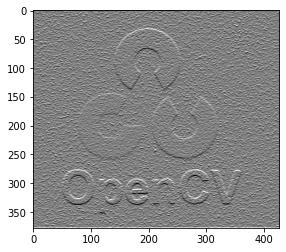

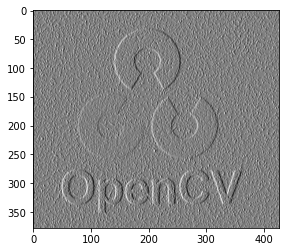

In [65]:
# 5b. test Prewitt edge detection filter
img_obj.myEdgeDetection(img_obj.gray_img, "Prewitt")
img_obj.show_img(img_obj.img_prewitt_vert, 'gray')
img_obj.show_img(img_obj.img_prewitt_horz, 'gray')

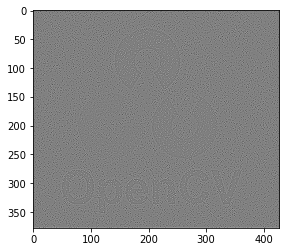

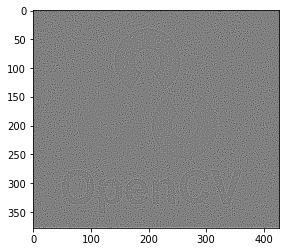

In [66]:
# 5c. test Laplace edge detection filter
img_obj.myEdgeDetection(img_obj.gray_img, "Laplace")
img_obj.show_img(img_obj.img_laplace_1, 'gray')
img_obj.show_img(img_obj.img_laplace_2, 'gray')